In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")

Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from matplotlib.patches import Patch
from returns.result import Failure, Result, Success
from sklearn.pipeline import Pipeline

import hydro_forecasting.experiment_utils.checkpoint_manager as checkpoint_manager
from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.models.dummy import LitRepeatLastValues, RepeatLastValuesConfig
from hydro_forecasting.models.ealstm import EALSTMConfig, LitEALSTM
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.models.tsmixer import LitTSMixer, TSMixerConfig
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from hydro_forecasting.preprocessing.normalize import NormalizeTransformer
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer
# from hydro_forecasting.models.tft import LitTFT, TFTConfig


---

In [3]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [4]:
REGIONS = ["CA"]

COUNTRY = "tajikistan"

MODEL_TYPES = [
    "ealstm",
    "tide",
    "tsmixer",
]

In [5]:
ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/ealstm.yaml"
# tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tft.yaml"
tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tide.yaml"
tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tsmixer.yaml"


# tft_hp = hp_from_yaml("tft", tft_yaml)
tide_hp = hp_from_yaml("tide", tide_yaml)
ealstm_hp = hp_from_yaml("ealstm", ealstm_yaml)
tsmixer_hp = hp_from_yaml("tsmixer", tsmixer_yaml)

In [6]:
# TFT_config = TFTConfig(**tft_hp)
EALSTM_config = EALSTMConfig(**ealstm_hp)
TiDE_config = TiDEConfig(**tide_hp)
TSMixer_config = TSMixerConfig(**tsmixer_hp)

dummy_config = RepeatLastValuesConfig(
    input_len=tide_hp["input_len"],
    input_size=tide_hp["input_size"],
    output_len=tide_hp["output_len"],
)

---

In [7]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


country_ids = load_basin_ids(COUNTRY)

In [8]:
print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 16 total CA basins in tajikistan


---

In [9]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": static_features},
}

In [10]:
feature_pipeline_benchmark = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline_benchmark = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline_benchmark = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config_benchmark = {
    "features": {"pipeline": feature_pipeline_benchmark},
    "target": {"pipeline": target_pipeline_benchmark},
    "static_features": {"pipeline": static_pipeline_benchmark, "columns": static_features},
}

In [11]:
region_time_series_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/timeseries/csv/{region}"
    for region in REGIONS
}

region_static_attributes_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/attributes/{region}" for region in REGIONS
}

In [12]:
tide_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tsmixer_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tsmixer_hp["input_len"],
    output_length=tsmixer_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

ealstm_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=ealstm_hp["input_len"],
    output_length=ealstm_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)


In [13]:
tide_data_module_benchmark = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config_benchmark,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tsmixer_data_module_benchmark = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tsmixer_hp["input_len"],
    output_length=tsmixer_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config_benchmark,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

ealstm_data_module_benchmark = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=ealstm_hp["input_len"],
    output_length=ealstm_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config_benchmark,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

In [14]:
def get_checkpoint_for_model(model_type: str, checkpoint_folder: Path, select_overall_best: bool = True):
    """
    Function to get the best checkpoint for a given model type
    """
    result = checkpoint_manager.get_checkpoint_path_to_load(
        base_checkpoint_load_dir=checkpoint_folder, model_type=model_type, select_overall_best=select_overall_best
    )
    return result


def unwrap(checkpoint: Result) -> Path:
    """
    Function to unwrap the checkpoint result
    """
    if isinstance(checkpoint, Failure):
        print(f"Failed to load checkpoint: {checkpoint.failure()}")
        return None
    elif isinstance(checkpoint, Success):
        return checkpoint.unwrap()


pretrained_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_{COUNTRY.lower()}/checkpoints"
)

finetuned_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_{COUNTRY.lower()}/checkpoints"
)

benchmark_checkpoint_dir = Path(
    "/Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_tajikistan/checkpoints"
)

In [15]:
tide_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)


tsmixer_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
tsmixer_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

ealstm_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

tsmixer_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

print(
    f"Pretrained checkpoints: {tide_pretrained_checkpoint}, {ealstm_pretrained_checkpoint}, {tsmixer_pretrained_checkpoint}"
)
print(
    f"Finetuned checkpoints: {tide_finetuned_checkpoint}, {ealstm_finetuned_checkpoint}, {tsmixer_finetuned_checkpoint}"
)
print(
    f"Benchmark checkpoints: {tide_benchmark_checkpoint}, {ealstm_benchmark_checkpoint}, {tsmixer_benchmark_checkpoint}"
)

Pretrained checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tide/run_0/attempt_0/tide-run0-attempt_0-epoch=65-val_loss=0.0504.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/ealstm/run_0/attempt_0/ealstm-run0-attempt_0-epoch=141-val_loss=0.0349.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tsmixer/run_0/attempt_0/tsmixer-run0-attempt_0-epoch=135-val_loss=0.0388.ckpt
Finetuned checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_tajikistan/checkpoints/tide/run_0/attempt_0/tide-run0-attempt_0-epoch=10-val_loss=0.0320.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_tajikistan/checkpoints/ealstm/run_0/attempt_0/ealstm-run0-attempt_0-epoch=03-val_loss=0.0269.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_tajikis

In [16]:
dummy_model = LitRepeatLastValues(config=dummy_config)
ealstm_benchmark_model = LitEALSTM.load_from_checkpoint(ealstm_benchmark_checkpoint, config=EALSTM_config)
tide_benchmark_model = LitTiDE.load_from_checkpoint(tide_benchmark_checkpoint, config=TiDE_config)
tsmixer_benchmark_model = LitTSMixer.load_from_checkpoint(tsmixer_benchmark_checkpoint, config=TSMixer_config)

ealstm_pretrained_model = LitEALSTM.load_from_checkpoint(ealstm_pretrained_checkpoint, config=EALSTM_config)
tide_pretrained_model = LitTiDE.load_from_checkpoint(tide_pretrained_checkpoint, config=TiDE_config)
tsmixer_pretrained_model = LitTSMixer.load_from_checkpoint(tsmixer_pretrained_checkpoint, config=TSMixer_config)

ealstm_finetuned_model = LitEALSTM.load_from_checkpoint(ealstm_finetuned_checkpoint, config=EALSTM_config)
tide_finetuned_model = LitTiDE.load_from_checkpoint(tide_finetuned_checkpoint, config=TiDE_config)
tsmixer_finetuned_model = LitTSMixer.load_from_checkpoint(tsmixer_finetuned_checkpoint, config=TSMixer_config)


# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "ealstm_benchmark": (ealstm_benchmark_model, ealstm_data_module_benchmark),
    "ealstm_pretrained": (ealstm_pretrained_model, ealstm_data_module),
    "ealstm_finetuned": (ealstm_finetuned_model, ealstm_data_module),
    "tide_benchmark": (tide_benchmark_model, tide_data_module_benchmark),
    "tide_pretrained": (tide_pretrained_model, tide_data_module),
    "tide_finetuned": (tide_finetuned_model, tide_data_module),
    "tsmixer_benchmark": (tsmixer_benchmark_model, tsmixer_data_module_benchmark),
    "tsmixer_pretrained": (tsmixer_pretrained_model, tsmixer_data_module),
    "tsmixer_finetuned": (tsmixer_finetuned_model, tsmixer_data_module),
}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "cpu", "devices": 1},
)

In [17]:
# Run evaluation
results = evaluator.test_models()

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: f4f91ab6-3927-547e-b1c1-7c7c4ae17e31
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/f4f91ab6-3927-547e-b1c1-7c7c4ae17e31
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecastin

Testing ealstm_benchmark...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07791634649038315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecastin

Testing ealstm_pretrained...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03635948896408081
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Data preparation has already run.
INFO:hydro_forecasting.data.in_memory_datamodule:Loading test data for 16 basins...
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'test' chunk data loaded for 16 basins. Shape: (26619, 12). Est. Mem: 1.22 MB


Testing ealstm_finetuned...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.032803308218717575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: f4f91ab6-3927-547e-b1c1-7c7c4ae17e31
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/f4f91ab6-3927-547e-b1c1-7c7c4ae17e31
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecastin

Testing tide_benchmark...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 43.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.0830402597784996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecastin

Testing tide_pretrained...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 53.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03901425749063492
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Data preparation has already run.
INFO:hydro_forecasting.data.in_memory_datamodule:Loading test data for 16 basins...
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'test' chunk data loaded for 16 basins. Shape: (26619, 12). Est. Mem: 1.22 MB


Testing tide_finetuned...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 47.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03371383249759674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: f4f91ab6-3927-547e-b1c1-7c7c4ae17e31
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/f4f91ab6-3927-547e-b1c1-7c7c4ae17e31
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecastin

Testing tsmixer_benchmark...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.09295931458473206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecastin

Testing tsmixer_pretrained...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 12/12 [00:03<00:00,  3.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.034249648451805115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Data preparation has already run.
INFO:hydro_forecasting.data.in_memory_datamodule:Loading test data for 16 basins...
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'test' chunk data loaded for 16 basins. Shape: (26619, 12). Est. Mem: 1.22 MB


Testing tsmixer_finetuned...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 12/12 [00:02<00:00,  4.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03199288249015808
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [53]:
from typing import Any


def filter_growing_season_polars(eval_results: dict[str, Any]) -> dict[str, Any]:
    """
    Filter evaluation results to include only data from the growing season (April to October), using Polars.

    Args:
        eval_results: dictionary containing evaluation results with a 'df' key,
                      where 'df' is a Polars DataFrame.

    Returns:
        dictionary with filtered Polars DataFrame and original metrics.
    """
    # Create a copy of the results to avoid modifying the original
    filtered_results = eval_results.copy()

    # Extract the Polars DataFrame
    # Use clone() for a deep copy in Polars
    df = eval_results["df"].clone()

    # Ensure 'date' column exists
    if "date" not in df.columns:
        raise ValueError("DataFrame must contain a 'date' column.")

    # Filter for growing season (April to October) using Polars expressions
    # Month numbers are 1 (January) to 12 (December)
    # Polars dt.month() returns month number
    growing_season_df = df.filter(
        (pl.col("date").dt.month() >= 4)
        & (pl.col("date").dt.month() <= 9)  # Corrected to month < 10 (i.e. <=9 for April to September)
        # If October is inclusive, it should be <= 10
    )
    # If your original code meant df["date"].dt.month < 10 (i.e., up to and including September),
    # then the condition should be (pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() < 10)
    # I will use the original logic: April to September (month < 10)

    growing_season_df = df.filter((pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() < 10))

    # Replace the dataframe in the results
    filtered_results["df"] = growing_season_df

    return filtered_results


def process_seasonal_results_polars(
    results: dict[str, Any],
    evaluator: Any,  # Replace Any with the actual type of TSForecastEvaluator if available
    model_keys: list[str] = None,
) -> dict[str, Any]:
    """
    Process specified model results to get seasonal metrics using Polars DataFrames.

    Args:
        results: dictionary containing results for all models.
        evaluator: Evaluator object with _calculate_overall_metrics and
                   _calculate_basin_metrics methods that can handle Polars DataFrames.
                   (As per evaluators.py, these methods already use Polars)
        model_keys: list of model keys to process. If None, process all keys in results.

    Returns:
        dictionary with seasonal results for the specified models.
    """
    seasonal_results = {}

    # If model_keys is not provided, use all keys in results
    if model_keys is None:
        model_keys = list(results.keys())  # Use list() for iteration if modifying dict

    # Process each model
    for key in model_keys:
        # Skip if the key doesn't exist in results
        if key not in results:
            print(f"Warning: Model key '{key}' not found in results. Skipping.")
            continue

        # Filter for growing season using the Polars version
        seasonal_model_results = filter_growing_season_polars(results[key])

        # Calculate metrics
        # Assuming _calculate_overall_metrics and _calculate_basin_metrics from
        # TSForecastEvaluator already accept Polars DataFrames
        seasonal_model_results["metrics"] = evaluator._calculate_overall_metrics(seasonal_model_results["df"])
        seasonal_model_results["basin_metrics"] = evaluator._calculate_basin_metrics(seasonal_model_results["df"])

        # Store in results dictionary
        seasonal_results[key] = seasonal_model_results

    return seasonal_results


seasonal_results = process_seasonal_results_polars(results, evaluator, model_keys=list(models_and_datamodules.keys()))

In [54]:
def generate_color_triplets(
    num_triplets: int,
    base_palette: str = "husl",
    lightness_factor_1: float = 0.5,
    lightness_factor_2: float = 0.8,
) -> list[str]:
    # Get base colors from seaborn
    base_colors = sns.color_palette(base_palette, n_colors=num_triplets // 2)

    # Create two lighter versions of each color with different lightness factors
    medium_colors = []
    light_colors = []

    for rgb in base_colors:
        # Convert to medium version
        medium_rgb = tuple(c + (1 - c) * lightness_factor_1 for c in rgb)
        medium_colors.append(medium_rgb)

        # Convert to lighter version
        light_rgb = tuple(c + (1 - c) * lightness_factor_2 for c in rgb)
        light_colors.append(light_rgb)

    # Combine base, medium, and light variants to create triplets
    color_triplets = []
    for base, medium, light in zip(base_colors, medium_colors, light_colors, strict=False):
        color_triplets.extend([base, medium, light])

    return color_triplets


In [55]:
sns.set_context(context="paper", font_scale=1.3)

---

In [56]:
def plot_metric_boxplot(
    evaluator_results: dict[str, dict],
    model_names: list[str],
    scenario_mapping: dict[str, str] = None,
    metric: str = "NSE",
    horizons: list[int] | None = None,
    fig_size: tuple[int, int] = (10, 6),
    title: str | None = None,
    palette: list[tuple] | None = None,
    individual_points: bool = False,
    num_variations: int = 3,
) -> tuple[plt.Figure, plt.Axes]:
    """
    Create a boxplot visualization of model performance metrics with a flexible scenario legend.

    Args:
        evaluator_results: dictionary containing evaluation results for each model
        model_names: list of model names to include in the plot
        scenario_mapping: dictionary mapping scenario suffixes to display names
                         (e.g., {"benchmark": "Benchmark models", "hii": "Low human influence"})
        metric: Performance metric to visualize (e.g., "NSE", "RMSE")
        horizons: Optional list of forecast horizons to include
        fig_size: Figure dimensions as (width, height)
        title: Custom plot title (auto-generated if None)
        palette: Color palette containing triplets of colors for each model
                (assumes colors are already organized in triplets [dark, medium, light])
        individual_points: Whether to show individual data points
        num_variations: Number of variations for each model (default is 3)

    Returns:
        Figure and Axes objects of the created plot
    """
    # Validate inputs
    if not model_names:
        raise ValueError("At least one model name must be provided")

    missing_models = [model for model in model_names if model not in evaluator_results]
    if missing_models:
        raise ValueError(f"Models not found in evaluator results: {missing_models}")

    # Create a DataFrame for all models' data
    all_data = []

    for model_name in model_names:
        # Extract basin metrics for this model
        basin_metrics = evaluator_results[model_name]["basin_metrics"]

        # Flatten the nested dictionary to a DataFrame
        for basin, horizon_data in basin_metrics.items():
            for horizon, metrics_dict in horizon_data.items():
                if metric in metrics_dict:
                    all_data.append(
                        {
                            "model": model_name,
                            "basin_id": basin,
                            "horizon": horizon,
                            "metric_value": metrics_dict[metric],
                        }
                    )

    df = pd.DataFrame(all_data)

    # Filter by horizons if specified
    if horizons:
        df = df[df["horizon"].isin(horizons)]

    # Determine available horizons after filtering
    available_horizons = sorted(df["horizon"].unique())

    # Extract unique base models and scenarios from model names
    base_models = set()
    scenarios = set()

    for model_name in model_names:
        parts = model_name.split("_")
        if len(parts) > 1:
            base_models.add(parts[0])
            scenarios.add(parts[1])

    # If no scenario mapping is provided, create a default one
    if scenario_mapping is None:
        scenario_mapping = {scenario: scenario.replace("_", " ").title() for scenario in scenarios}

    # Create color mapping between model names and colors
    color_map = {}
    base_model_to_color_index = {}

    # Associate each base model with a color index in the palette
    # This ensures each model gets a consistent set of colors
    for i, base_model in enumerate(sorted(base_models)):
        base_model_to_color_index[base_model] = i

    # Map each model_name to its appropriate color from the palette
    sorted_scenarios = sorted(scenarios)
    for model_name in model_names:
        parts = model_name.split("_")
        if len(parts) > 1:
            base_model = parts[0]
            scenario = parts[1]

            # Get the base color index for this model
            base_idx = base_model_to_color_index[base_model]

            # Determine the scenario index (e.g., benchmark=0, hii=1, similarity=2)
            scenario_idx = sorted_scenarios.index(scenario)

            # Calculate the palette index
            # Each base model gets num_variations colors (dark, medium, light)
            palette_idx = (base_idx * num_variations) + scenario_idx
            # Assign the color from the palette
            if palette_idx < len(palette):
                color_map[model_name] = palette[palette_idx]

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Create boxplot with custom palette
    sns.boxplot(
        x="horizon",
        y="metric_value",
        hue="model",
        data=df,
        palette=color_map,
        ax=ax,
        showfliers=not individual_points,
    )

    # Show individual points if requested
    if individual_points:
        sns.stripplot(
            x="horizon",
            y="metric_value",
            hue="model",
            data=df,
            palette=color_map,
            ax=ax,
            size=3,
            alpha=0.6,
            dodge=True,
            legend=False,
        )

    # Add median value labels for each model and horizon
    if len(model_names) <= 6:  # Only add labels if not too many models
        for h_idx, horizon in enumerate(available_horizons):
            for m_idx, model in enumerate(model_names):
                # Filter data for this horizon and model
                filtered = df[(df["horizon"] == horizon) & (df["model"] == model)]
                if not filtered.empty:
                    median = filtered["metric_value"].median()

                    # Calculate position for the text
                    model_count = len(model_names)
                    box_width = 0.8  # Default box width in seaborn
                    position = h_idx

                    # Calculate offset based on model index
                    if model_count > 1:
                        step = box_width / model_count
                        offset = step * (m_idx - (model_count - 1) / 2)
                        position += offset

                    ax.text(
                        position,
                        median + 0.02,
                        f"{median:.2f}",
                        ha="center",
                        va="bottom",
                        color="black",
                        fontweight="bold",
                        fontsize=8,
                    )

    # Set title and labels
    ax.set_xlabel("Forecast Horizon (days)")
    ax.set_ylabel(f"{metric} Value")

    if title:
        ax.set_title(title)

    # Remove the existing legend
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # Create new legend elements
    legend_elements = []

    # Add scenario elements with black patches and varying alpha
    for i, scenario in enumerate(sorted_scenarios):
        display_name = scenario_mapping.get(scenario, scenario)
        # Use decreasing alpha values for different scenarios
        alpha = 0.8 - (i * 0.25)
        alpha = max(0.3, alpha)  # Ensure minimum alpha

        legend_elements.append(Patch(facecolor="black", edgecolor="black", label=display_name, alpha=alpha))

    # Add model elements with their respective colors
    for base_model in sorted(base_models):
        # Use the first (darkest) color for each model in the legend
        base_idx = base_model_to_color_index[base_model]
        color_idx = base_idx * num_variations

        if color_idx < len(palette):
            color = palette[color_idx]
            display_name = base_model.upper()

            legend_elements.append(
                Patch(
                    facecolor=color,
                    edgecolor="black",
                    label=display_name,
                    alpha=0.8,  # Consistent alpha for model names
                )
            )

    # Create a single legend with all elements
    ax.legend(
        handles=legend_elements,
        loc="best",
        frameon=True,
        title=None,
        ncol=3,  # Adjust columns based on legend size
    )

    # Add grid lines for better readability
    ax.grid(True, axis="y", alpha=0.3, linestyle="--")

    # Apply styling
    sns.despine()
    plt.tight_layout()

    return fig, ax

In [57]:
def generate_color_variations_from_hex(
    hex_colors: list[str],
    variation_count: int = 3,
    lightness_factors: list[str] | None = None,
) -> list[tuple]:
    """
    Generate color variations (triplets or pairs) from a list of hex color codes.

    Args:
        hex_colors: list of hex color codes (e.g., ["#1f77b4", "#ff7f0e"])
        variation_count: Number of variations to generate for each color (2 for pairs, 3 for triplets)
        lightness_factors: Optional list of lightness factors to use for variations
                          If None, defaults are used based on variation_count

    Returns:
        list of RGB color tuples organized as variations of each base color

    Raises:
        ValueError: If variation_count is less than 1 or lightness_factors don't match variation_count
    """
    from matplotlib.colors import to_rgb

    # Validate inputs
    if variation_count < 1:
        raise ValueError("variation_count must be at least 1")

    # Default lightness factors based on variation count
    if lightness_factors is None:
        if variation_count == 2:
            lightness_factors = [0.6]  # Just one lighter version
        elif variation_count == 3:
            lightness_factors = [0.35, 0.75]  # Two lighter versions
        else:
            # Generate evenly spaced factors for other counts
            lightness_factors = [0.3 + (0.6 * i / (variation_count - 1)) for i in range(1, variation_count)]

    # Ensure lightness_factors match variation_count
    if len(lightness_factors) != variation_count - 1:
        raise ValueError(
            f"Expected {variation_count - 1} lightness factors for {variation_count} variations, got {len(lightness_factors)}"
        )

    # Convert hex colors to RGB
    base_colors = [to_rgb(hex_color) for hex_color in hex_colors]

    # Create lighter versions of each color with different lightness factors
    variations = [base_colors]  # Start with original colors

    for factor in lightness_factors:
        # Create a lighter version for each base color
        lighter_colors = []
        for rgb in base_colors:
            lighter_rgb = tuple(c + (1 - c) * factor for c in rgb)
            lighter_colors.append(lighter_rgb)
        variations.append(lighter_colors)

    # Interleave the variations to group them by base color
    color_variations = []
    for color_set in zip(*variations, strict=False):
        color_variations.extend(color_set)

    return color_variations


hex_codes = ["#4682B4", "#CD5C5C", "#009E73", "#9370DB"]
color_triplets = generate_color_variations_from_hex(hex_codes, variation_count=3)


In [58]:
list(models_and_datamodules.keys())

['ealstm_benchmark',
 'ealstm_pretrained',
 'ealstm_finetuned',
 'tide_benchmark',
 'tide_pretrained',
 'tide_finetuned',
 'tsmixer_benchmark',
 'tsmixer_pretrained',
 'tsmixer_finetuned']

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


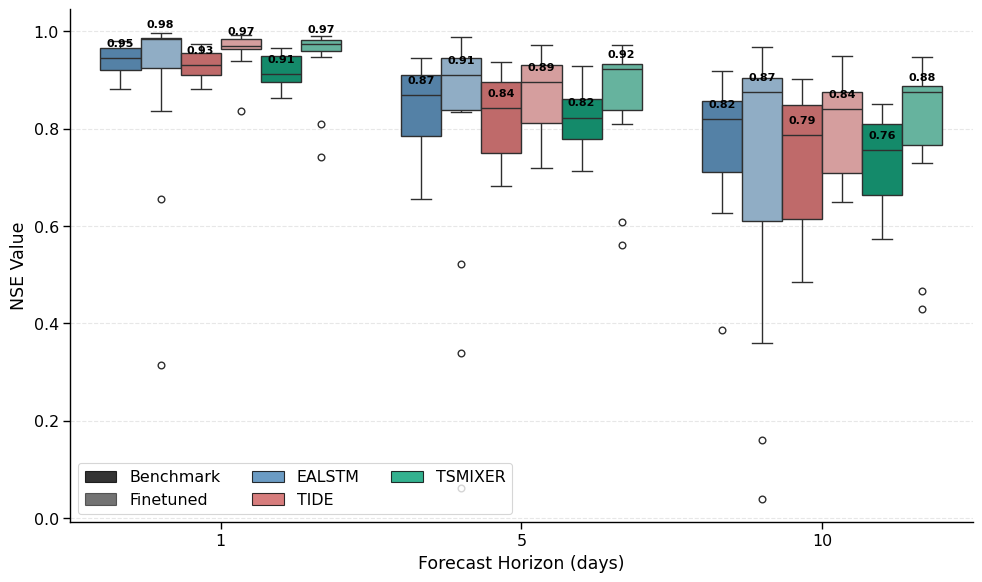

In [59]:
palette = generate_color_triplets(3)

fig, axes = plot_metric_boxplot(
    evaluator_results=seasonal_results,
    model_names=[
        "ealstm_benchmark",
        # "ealstm_pretrained",
        "ealstm_finetuned",
        "tide_benchmark",
        # "tide_pretrained",
        "tide_finetuned",
        "tsmixer_benchmark",
        # "tsmixer_pretrained",
        "tsmixer_finetuned",
    ],
    scenario_mapping={
        "benchmark": "Benchmark",
        # "pretrained": "Pretrained",
        "finetuned": "Finetuned",
    },
    metric="NSE",
    horizons=[1, 5, 10],
    palette=color_triplets,
    num_variations=3,
)

plt.show()


In [60]:
def plot_model_cdf_grid(
    seasonal_results: dict,
    model_names: list[str],
    scenario_mapping: dict[str, str] = None,
    horizons: list[int] | None = None,
    palette: list[str] = None,
    num_variations: int = 3,
    fig_size: tuple[int, int] = (10, 7),
) -> tuple[plt.Figure, list[plt.Axes]]:
    """
    Plot a grid of CDF curves for different models and prediction horizons with
    standardized x-axis limits per horizon.

    Args:
        seasonal_results: dictionary containing model evaluation results by basin and horizon
        model_names: list of model names to include in the plot (format: "model_scenario")
        scenario_mapping: dictionary mapping scenario suffixes to display names
                         (e.g., {"benchmark": "Benchmark", "hii": "Low human influence"})
        horizons: list of forecast horizons to include
        palette: Color palette for different models and their variations
        num_variations: Number of variations for each model (scenarios)
        fig_size: Figure dimensions as (width, height)

    Returns:
        tuple containing the figure and list of axes
    """
    # Extract unique base models from model names
    if horizons is None:
        horizons = [1, 5, 10]
    base_models = set()
    scenarios = set()

    for model_name in model_names:
        parts = model_name.split("_")
        if len(parts) > 1:
            base_models.add(parts[0])
            scenarios.add(parts[1])

    # Sort base models and scenarios for consistent ordering
    base_models = sorted(base_models)
    scenarios = sorted(scenarios)

    # If no scenario mapping is provided, create a default one
    if scenario_mapping is None:
        scenario_mapping = {scenario: scenario.replace("_", " ").title() for scenario in scenarios}

    # Define x-axis limits for each horizon row
    horizon_xlims = {
        1: (0.8, 1.0),  # 1-day horizon: 0.8 to 1.0
        5: (0.4, 1.0),  # 5-day horizon: 0.4 to 1.0
        10: (-0.2, 1.0),  # 10-day horizon: -0.2 to 1.0
    }

    # Create color mapping between model names and colors
    color_map = {}
    base_model_to_color_index = {}

    # Associate each base model with a color index in the palette
    for i, base_model in enumerate(base_models):
        base_model_to_color_index[base_model] = i

    # Map each model_name to its appropriate color from the palette
    for model_name in model_names:
        parts = model_name.split("_")
        if len(parts) > 1:
            base_model = parts[0]
            scenario = parts[1]

            # Get the base color index for this model
            base_idx = base_model_to_color_index[base_model]

            # Determine the scenario index
            scenario_idx = scenarios.index(scenario)

            # Calculate the palette index
            palette_idx = (base_idx * num_variations) + scenario_idx

            # Assign the color from the palette
            if palette and palette_idx < len(palette):
                color_map[model_name] = palette[palette_idx]

    # Create figure and subplots
    fig, axes = plt.subplots(len(horizons), len(base_models), figsize=fig_size)

    # Handle case where there's only one horizon or one model
    if len(horizons) == 1 and len(base_models) == 1:
        axes = np.array([[axes]])
    elif len(horizons) == 1:
        axes = axes.reshape(1, -1)
    elif len(base_models) == 1:
        axes = axes.reshape(-1, 1)

    # Loop through each row (horizon)
    for i, horizon in enumerate(horizons):
        # Loop through each column (base model)
        for j, base_model in enumerate(base_models):
            ax = axes[i, j]

            # For each scenario of this base model
            for scenario in scenarios:
                model_key = f"{base_model}_{scenario}"

                # Skip if this model_scenario combination doesn't exist
                if model_key not in model_names:
                    continue

                # Extract NSE values for the specific horizon
                nse_values = []

                # Get the values
                if model_key in seasonal_results:
                    for basin, metrics in seasonal_results[model_key]["basin_metrics"].items():
                        if horizon in metrics and "NSE" in metrics[horizon]:
                            val = metrics[horizon]["NSE"]
                            # Convert numpy float32 to Python float if needed
                            if hasattr(val, "item"):
                                val = val.item()
                            # Only add non-NaN values
                            if not np.isnan(val):
                                nse_values.append(val)

                # Plot CDF if we have data
                if nse_values:
                    # Sort values for CDF
                    nse_values.sort()

                    # Calculate cumulative probabilities
                    prob = np.arange(1, len(nse_values) + 1) / len(nse_values)

                    # Plot CDF curve
                    ax.plot(
                        nse_values,
                        prob,
                        label=scenario_mapping.get(scenario, scenario),
                        color=color_map.get(model_key, "black"),
                        linewidth=1.8,
                    )

                    # Calculate and plot median
                    median_val = np.median(nse_values)
                    ax.axvline(
                        x=median_val,
                        color=color_map.get(model_key, "black"),
                        linestyle="--",
                        linewidth=1.5,
                    )

            # Set standardized x-axis limits based on horizon
            if horizon in horizon_xlims:
                ax.set_xlim(horizon_xlims[horizon])

            # Ensure 1.0 is included in the x-ticks
            current_ticks = list(ax.get_xticks())
            if 1.0 not in current_ticks:
                current_ticks.append(1.0)
                ax.set_xticks(sorted(current_ticks))

            # Add titles and labels
            if i == 0:
                ax.set_title(base_model.upper(), fontsize=14)
            if j == 0:
                ax.set_ylabel(f"{horizon} Day - CDF", fontsize=12)
            if i == len(horizons) - 1:
                ax.set_xlabel("NSE", fontsize=12)

            # Add grid
            ax.grid(True, alpha=0.3, linestyle="--")

            # Set y-axis to show values from 0 to 1
            ax.set_ylim(0, 1)

    # Create a legend with all scenarios in black with varying alpha
    handles = []

    # Add each scenario with decreasing alpha
    for i, scenario in enumerate(scenarios):
        # Calculate alpha for this scenario (starting at 1.0, decreasing by 0.2)
        alpha = max(0.3, 1.0 - (i * 0.4))

        # Add line to legend
        handles.append(plt.Line2D([0], [0], color="black", linewidth=1.8, alpha=alpha))

    # Add median line
    handles.append(plt.Line2D([0], [0], color="black", linewidth=1.5, linestyle="--"))

    # Create labels from scenario mapping
    labels = [scenario_mapping.get(scenario, scenario) for scenario in scenarios]
    labels.append("Median value")

    # Add legend
    fig.legend(
        handles=handles,
        labels=labels,
        loc="lower center",
        ncol=len(scenarios) + 1,  # +1 for the median line
        bbox_to_anchor=(0.5, 0.01),
        fontsize=12,
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    sns.despine()

    return fig, axes

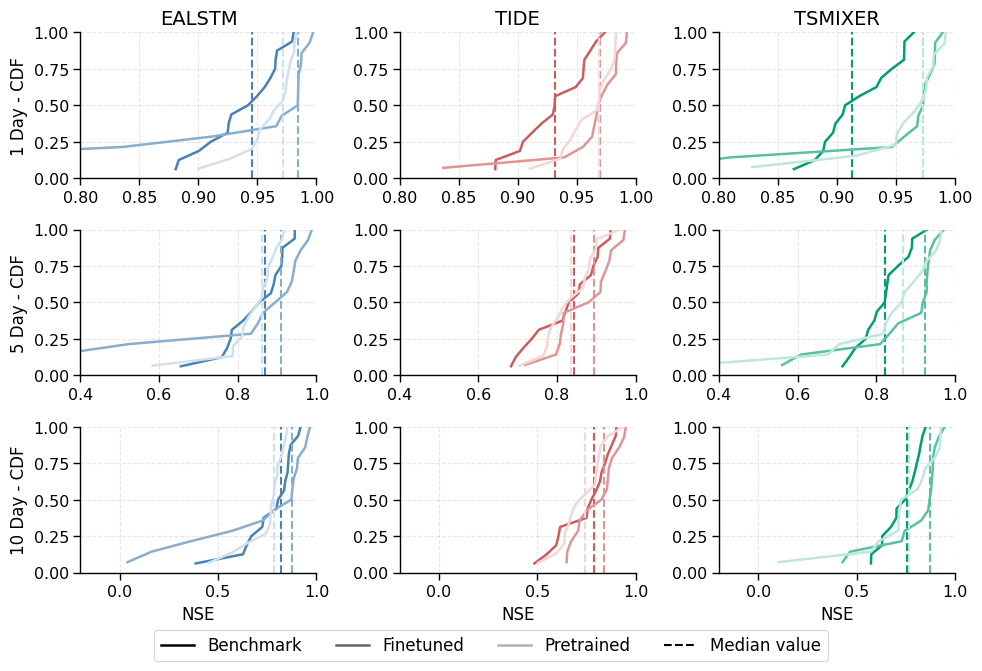

In [35]:
# Call refactored function
fig, axes = plot_model_cdf_grid(
    seasonal_results=seasonal_results,
    model_names=list(models_and_datamodules.keys()),
    scenario_mapping={
        "benchmark": "Benchmark",
        "pretrained": "Pretrained",
        "finetuned": "Finetuned",
    },
    horizons=[1, 5, 10],
    palette=color_triplets,
    num_variations=3,
)

# # Save and display plot
plt.show()